In [1]:


# !pip install tensorflow_addons==0.10.0

# from __future__ import print_function
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Dropout, Permute, Activation, Flatten, BatchNormalization, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,  Embedding, Input, MaxPooling1D, Concatenate, SpatialDropout1D, InputSpec
#from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
import random
from random import shuffle
#random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from time import time
import sklearn
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet 
AUTOTUNE = tf.data.experimental.AUTOTUNE

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'testing_ideas/'


Mounted at /content/gdrive


In [3]:
# Load pre-processed (tokenized) IMBD data from keras
 

vocab_size = len(imdb.get_word_index())
#sp = spacy.load('en_core_web_sm')
#len(sp.Defaults.stop_words) = 326

stop_words_rate = 0.0

n_stop_words = stop_words_rate * 326

# set parameters:

literacy_rate = 1.0

max_features = int(vocab_size * literacy_rate)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, skip_top=n_stop_words)

x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

maxlen = 600 # truncate/pad reviews to an equal length of 600 tokens. 

X_total = sequence.pad_sequences(x_total, maxlen=maxlen, truncating='pre')


print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences
x_train shape: (25000, 600)
x_test shape: (25000, 600)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
weights_init_he = 'he_uniform'

embedding_dims = 64

dr_dense = 0.2
dr_words = 0.25
l2_penalty_em = 2e-3

padding = 'same'

inputs = Input(shape=(maxlen,))

embedding = Embedding(max_features, embedding_dims, embeddings_regularizer=regularizers.l2(l2_penalty_em))(inputs)

embedding_T = Permute((2,1))(embedding)

word_dr1 = SpatialDropout1D(dr_words)(embedding_T)

embedding_dr = Permute((2,1))(word_dr1)

conv_s = Conv1D(filters=600, kernel_size=3, activation='relu', kernel_initializer= weights_init_he, padding = padding)(embedding_dr)

conv2_s = Conv1D(filters=600, kernel_size=7, activation='relu', kernel_initializer= weights_init_he, padding = padding)(embedding_dr)

pool1_s = GlobalMaxPooling1D()(conv_s)

pool2_s = GlobalMaxPooling1D()(conv2_s)

merged_s = Concatenate()([pool1_s, pool2_s])

flatten_s = Flatten()(merged_s)

outputs_drop = Dropout(dr_dense)(flatten_s)

outputs_s = Dense(1, activation='sigmoid')(outputs_drop)

model_s = Model(inputs=inputs, outputs=outputs_s)

In [5]:
# define callbacks/early stopping

rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.95, patience=3, verbose=1)

es_on_loss = EarlyStopping(monitor='val_accuracy', verbose=1, patience=52)

callbacks = [es_on_loss, rlrop]

opt_Adam = Adam(learning_rate=1e-3, beta_1=0.98, beta_2=0.999)#, epsilon=1e-08)#, decay=0.001)

model_s.compile(loss='binary_crossentropy', optimizer=opt_Adam, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 64)      5669376     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 600)      0           embedding[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 64, 600)      0           permute[0][0]                    
______________________________________________________________________________________________

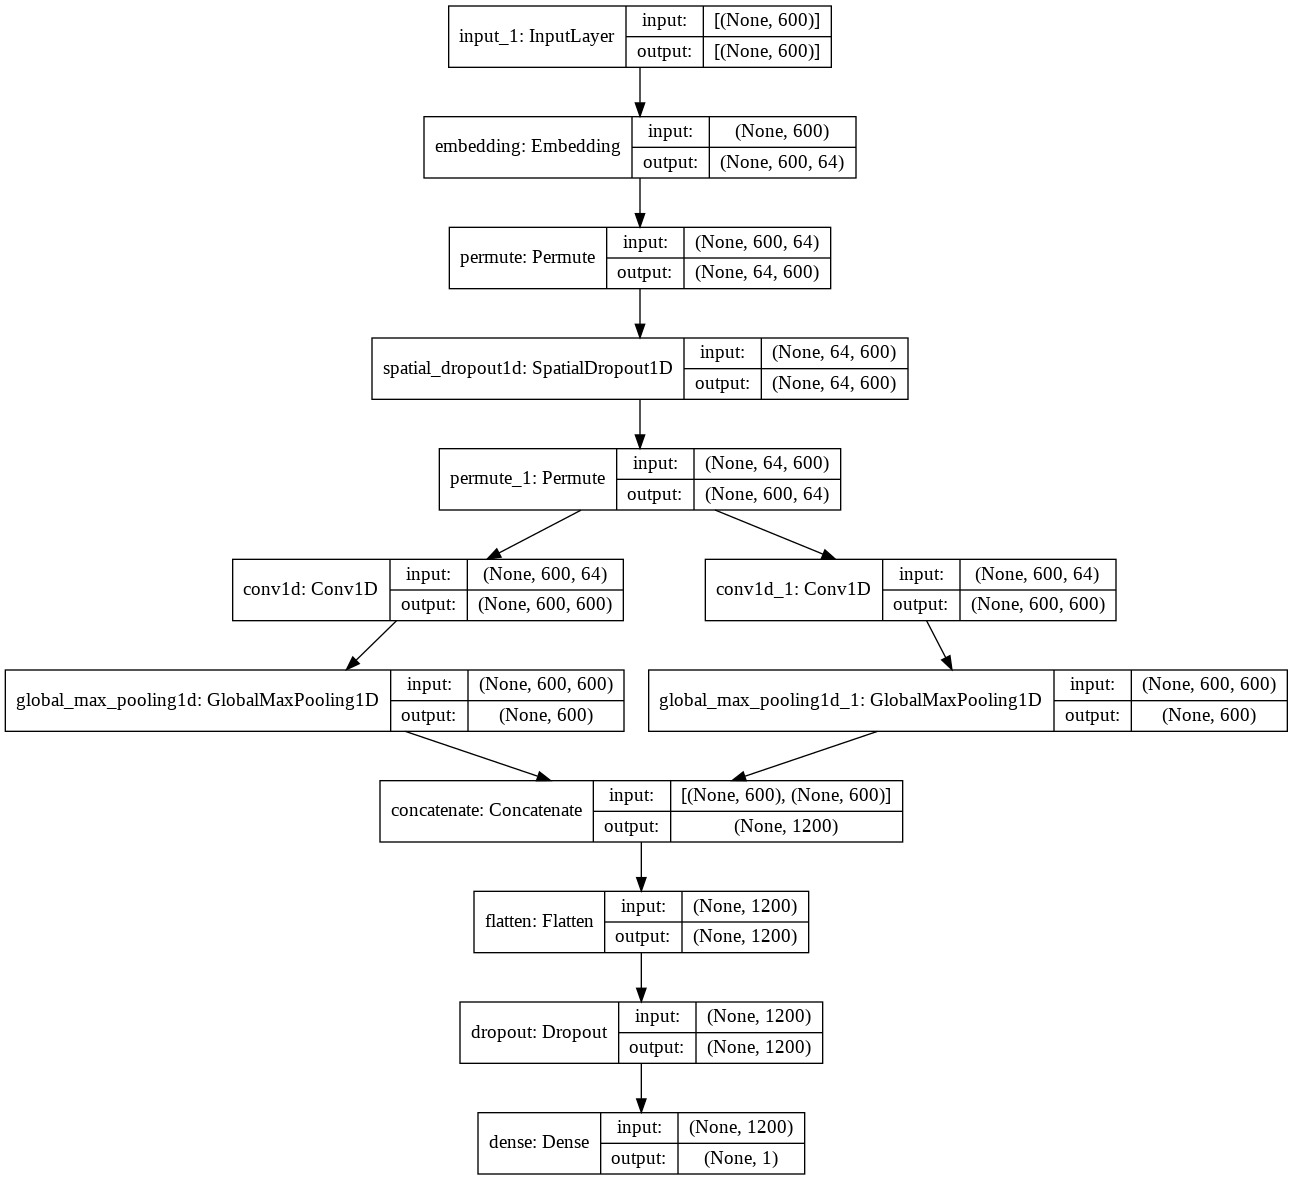

In [6]:
# summarize

print(model_s.summary())

plot_model(model_s, show_shapes=True) #, to_file='multichannel.png')

In [25]:
history = model_s.fit(x_train, y_train, batch_size=32, epochs=800, verbose =1, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0486 - accuracy: 0.9956 - val_loss: 0.2455 - val_accuracy: 0.9177
Epoch 2/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0484 - accuracy: 0.9949 - val_loss: 0.2435 - val_accuracy: 0.9173
Epoch 3/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0473 - accuracy: 0.9954 - val_loss: 0.2430 - val_accuracy: 0.9177
Epoch 4/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0475 - accuracy: 0.9956 - val_loss: 0.2430 - val_accuracy: 0.9182
Epoch 5/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0466 - accuracy: 0.9955 - val_loss: 0.2434 - val_accuracy: 0.9176
Epoch 6/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0475 - accuracy: 0.9948 - val_loss: 0.2419 - val_accuracy: 0.9177
Epoch 7/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0478 - accuracy: 0.9947 - val_loss: 0.2433 - val_ac

In [26]:
history_df = pd.DataFrame(history.history)

In [27]:
# accuracy on the test set

history_df['val_accuracy'].max()

0.9210000038146973

In [7]:
#https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset

INDEX_FROM=3 
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

#word_to_id={k:(v) for k,v in word_to_id.items()}
word_to_id={k:(v) for k,v in word_to_id.items() if v < max_features}
id_to_word = {value:key for key,value in word_to_id.items()}

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

In [8]:
# Each synset contains one or more lemmas, which represent a specific sense of a specific word.
# https://www.nltk.org/howto/wordnet.html  

def get_synonyms(word):

  word_source = id_to_word[word]

  synonyms_source = set()
  for syn in wordnet.synsets(str(word_source).strip("''")): 
    for l in syn.lemma_names(): 
        synonym = l.replace("_", " ").replace("-", " ").lower()
        synonym = "".join([char for char in synonym if char in 'qwertyuiopasdfghjklzxcvbnm'])
        synonyms_source.add(synonym) 

  if word_source in synonyms_source:
    synonyms_source.remove(word_source)

  synonyms = [word_to_id[word_s] for word_s in list(synonyms_source) if word_s in word_to_id.keys()] 

  return synonyms

In [9]:
def get_rand_syn(word):

  synonyms = get_synonyms(word)

  if len(synonyms) > 1:
        synonym = random.choice(synonyms)
  else:
    synonym = word
    
  return synonym             

In [10]:
def random_synonym_replacement(text, p_w = 0.25):
  length = len(text)
  
  if 1 in list(text):
    count = list(text).index(1) + 1
  else:
    count = 0

  #if length == 1:
  #  return text

  #randomly replace words with random synonyms 
  #text_d = []
  text_d = list(text[:count])

  while count < length:
    r = random.uniform(0, 1)
    if (r > p_w) or (id_to_word[text[count]] in stop_words):
      text_d.append(text[count])
      count = count + 1
    else:
      text_d.append(get_rand_syn(text[count]))
      count = count + 1

  return text_d

In [58]:
# Example of NLTK's synonyms 

syn_test = get_synonyms(word_to_id['movie'])

In [59]:
for word_id in syn_test:
  print(id_to_word[word_id] + '\n')

flick

film

picture

pic



In [11]:
def ids_to_words(review):
  index_start = 0
  review = list(review)
  if 1 in review:
    index_start = review.index(1) + 1

  return ' '.join(id_to_word[id] for id in review[index_start:])


In [55]:
# example of a review

ids_to_words(x_train[7])

"the hamiltons tells the story of the four hamilton siblings teenager francis cory knauf twins wendell joseph mckelheer darlene mackenzie firgens the eldest david samuel who is now the surrogate parent in charge the hamilton's move house a lot franics is unsure why is unhappy with the way things are the fact that his brother's sister kidnap imprison murder people in the basement doesn't help relax or calm francis' nerves either francis know's something just isn't right when he eventually finds out the truth things will never be the same again br br co written co produced directed by mitchell altieri phil flores as the butcher brothers who's only other film director's credit so far is the april fool's day 2008 remake enough said this was one of the 'films to die for' at the 2006 after dark horrorfest or whatever it's called in keeping with pretty much all the other's i've seen i thought the hamiltons was complete total utter crap i found the character's really poor very unlikable the sl

In [56]:
x_train_test_syn = list(random_synonym_replacement(list(x_train[7]), p_w=0.5))

In [57]:
# random synonym replacement example

ids_to_words(x_train_test_syn)

"the hamiltons tells the narration of the iv hamilton siblings adolescent francis cory knauf twins wendell joseph mckelheer darlene mackenzie firgens the eldest david samuel who is now the surrogate parent in charge the hamilton's move house a set franics is unsure why is unhappy with the room matter are the fact that his brother's sis kidnap imprison murder people in the basement doesn't service unwind or calm francis' cheek either francis know's something just isn't correct when he eventually get out the verity matter will never be the same again br br colorado scripted colorado produce maneuver by mitchell altieri phil flores as the macho brothers who's only other pic director's mention so far is the april fool's daytime 2008 remake adequate said this was unrivaled of the pic to die for' at the 2006 after night horrorfest or whatever it's foretell in keeping with middling practically all the other's i've understand i thought the hamiltons was sodding total utter defecate i notice th

In [12]:
def generator_aug(X_data, y_data, batch_size):

  samples_per_epoch = X_data.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter=0

  while 1:

    X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('int32')
    y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('int32')
    
    X_batch_rand_syn  = np.array([random_synonym_replacement(item, p_w=0.25) for item in X_batch]).astype('int32') 

    counter += 1
    yield X_batch_rand_syn, y_batch

    #restart counter for the next epoch
    if counter >= number_of_batches:
        counter = 0

In [19]:
import time 

batch_size = 32

start_t = time.time()
history_wd = model_s.fit(
    generator_aug(x_train,y_train,batch_size),
    epochs=800,
    steps_per_epoch = x_train.shape[0]/batch_size, 
    validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

duration = time.time() - start_t
print(f'Execution = {duration / 3600.0} hours.')

Epoch 1/800
781/781 [==============================] - 107s 137ms/step - loss: 0.0435 - accuracy: 0.9943 - val_loss: 0.2357 - val_accuracy: 0.9158
Epoch 2/800
781/781 [==============================] - 107s 137ms/step - loss: 0.0420 - accuracy: 0.9953 - val_loss: 0.2355 - val_accuracy: 0.9155
Epoch 3/800
781/781 [==============================] - 107s 137ms/step - loss: 0.0426 - accuracy: 0.9943 - val_loss: 0.2355 - val_accuracy: 0.9158
Epoch 4/800
781/781 [==============================] - 106s 136ms/step - loss: 0.0435 - accuracy: 0.9938 - val_loss: 0.2354 - val_accuracy: 0.9156

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0956635469483444e-05.
Epoch 5/800
781/781 [==============================] - 106s 136ms/step - loss: 0.0420 - accuracy: 0.9947 - val_loss: 0.2351 - val_accuracy: 0.9159
Epoch 6/800
781/781 [==============================] - 106s 136ms/step - loss: 0.0422 - accuracy: 0.9948 - val_loss: 0.2349 - val_accuracy: 0.9164
Epoch 7/800
781/781 [===============

In [20]:
historywd_df = pd.DataFrame(history_wd.history)

In [21]:
# random synonym replacement; accuracy on the test set 

historywd_df['val_accuracy'].max()

0.916920006275177

In [63]:
# No L2 regularization (Embedding L2 lambda = 0) + dr_words = 0.25

# max val_accuracy = 0.8993

history = model_s.fit(x_train, y_train, batch_size=32, epochs=800, verbose =1, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/800
782/782 [==============================] - 37s 47ms/step - loss: 0.5407 - accuracy: 0.7061 - val_loss: 0.2903 - val_accuracy: 0.8850
Epoch 2/800
782/782 [==============================] - 37s 47ms/step - loss: 0.2368 - accuracy: 0.9054 - val_loss: 0.2557 - val_accuracy: 0.8994
Epoch 3/800
782/782 [==============================] - 36s 47ms/step - loss: 0.1533 - accuracy: 0.9416 - val_loss: 0.2713 - val_accuracy: 0.8887
Epoch 4/800
782/782 [==============================] - 36s 47ms/step - loss: 0.0981 - accuracy: 0.9646 - val_loss: 0.3332 - val_accuracy: 0.8694
Epoch 5/800
782/782 [==============================] - 36s 47ms/step - loss: 0.0714 - accuracy: 0.9729 - val_loss: 0.3584 - val_accuracy: 0.8641

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 6/800
782/782 [==============================] - 36s 47ms/step - loss: 0.0459 - accuracy: 0.9848 - val_loss: 0.3497 - val_accuracy: 0.8783
Epoch 7/800
782/782 [============================

In [64]:
history_df = pd.DataFrame(history.history)

In [65]:
history_df['val_accuracy'].max()

0.8993600010871887

In [91]:
# No word masking (only embedding L2)
# dr_words = 0.0
# l2_penalty_em = 2e-3

# max val_accuracy = 0.9052

history = model_s.fit(x_train, y_train, batch_size=32, epochs=800, verbose =1, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3895 - val_accuracy: 0.9038
Epoch 2/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3898 - val_accuracy: 0.9034
Epoch 3/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3925 - val_accuracy: 0.9034
Epoch 4/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3909 - val_accuracy: 0.9034

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.2779280405084136e-05.
Epoch 5/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3880 - val_accuracy: 0.9035
Epoch 6/800
782/782 [==============================] - 36s 46ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3903 - val_accuracy: 0.9033
Epoch 7/800
782/782 [===========================

In [92]:
history_df = pd.DataFrame(history.history)

In [93]:
history_df['val_accuracy'].max()

0.9052000045776367

In [77]:
# No embedding regularization, no word masking

# max val_accuracy = 0.8966

history = model_s.fit(x_train, y_train, batch_size=32, epochs=800, verbose =1, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/800
782/782 [==============================] - 37s 47ms/step - loss: 0.5261 - accuracy: 0.6989 - val_loss: 0.2614 - val_accuracy: 0.8917
Epoch 2/800
782/782 [==============================] - 37s 47ms/step - loss: 0.1601 - accuracy: 0.9410 - val_loss: 0.2547 - val_accuracy: 0.8966
Epoch 3/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0477 - accuracy: 0.9885 - val_loss: 0.3338 - val_accuracy: 0.8863
Epoch 4/800
782/782 [==============================] - 37s 47ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.4091 - val_accuracy: 0.8820
Epoch 5/800
782/782 [==============================] - 36s 47ms/step - loss: 0.0035 - accuracy: 0.9999 - val_loss: 0.4680 - val_accuracy: 0.8792

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 6/800
782/782 [==============================] - 36s 47ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5104 - val_accuracy: 0.8794
Epoch 7/800
782/782 [============================

In [80]:
history_df = pd.DataFrame(history.history)

In [81]:
history_df['val_accuracy'].max()

0.89656001329422